In [12]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline

import imageio     # To make the gif
import os        # To obtain the path of the Python document
import moviepy.editor as mp # To convert gif in mp4

import time     # To measure the time of execution
start_time = time.time()

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

RuntimeError: No ffmpeg exe could be found. Install ffmpeg on your system, or set the IMAGEIO_FFMPEG_EXE environment variable.

In [ ]:
# Data points generator: They belong to two different gaussian distributions in R^2 (their 2 classes)

def datagenerator(N,mean,cov):
    X = npr.multivariate_normal(mean,cov,N).T
    return X

In [ ]:
#Definition of activation functions:

# Pointwise ReLU

def ReLU(x):
    return np.maximum(x, 0)

# Pointwise truncated ReLU

def TrunReLU(x):
    return np.maximum(x, 0)+np.minimum(-x+1,0)

# Hyperbolic tangent

def tanh(x):
    return np.tanh(x)

In [ ]:
# Application of NODE x'=w*sigma(ax+b) for each time step

def NODE(X,w,a,b,T,M,names_figure):
    x1 = X.T.dot(a)+b
    x2 = sigma(x1)
    x3 = np.array([x2[i]*w for i in range(len(x2))]).T
    Z = X+x3
    
    T+=1
    if a[1]!=0:
        names_figure.append(plot(Z[:,:N0],Z[:,N0:],w,a,b,T,M))
    
    return Z,T,names_figure

In [ ]:
# Plot generator, for each time step T

def plot(Z0,Z1,w,a,b,T,M): 
    cwd = os.getcwd()
    newpath = os.path.join(cwd,"Images") # We create a new path to save the images
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    
    f = plt.figure();
    f.set_figwidth(10)
    f.set_figheight(7)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(sigma.__name__+' '+str(2*N0)+' Points     Time step '+str(T)+'     Number of switches: '+str(M)+'    mu: '+str(mu)+'    eps: '+str(eps))
    
    Z = np.concatenate((Z0,Z1),axis = 1)
              
    limx1 = np.floor(min(Z[0]))-abs(min(Z[0]))/4#-np.floor((max(Z[0])-min(Z[0]))/2)
    limx2 = np.ceil(max(Z[0]))+abs(max(Z[0]))/4#+np.floor((max(Z[0])-min(Z[0]))/2)
    limy1 = np.floor(min(Z[1]))-abs(min(Z[1]))/4#-np.floor((max(Z[1])-min(Z[1]))/2)
    limy2 = np.ceil(max(Z[1]))+abs(max(Z[1]))/4#+np.floor((max(Z[1])-min(Z[1]))/2)
    plt.xlim(limx1,limx2)
    plt.ylim(limy1,limy2)
    plt.fill_between((0,limx2),limy1,limy2,color = '#2E8B57',alpha =0.6)
    plt.fill_between((limx1,0),limy1,limy2,color = '#780116',alpha =0.8)
    
    # Plotting the datapoints
    
    plt.plot(Z0[0],Z0[1], 'D',color='#034748',markersize=8)
    plt.plot(Z1[0],Z1[1], 'o',color='#FF0000',markersize=8)
    
    #Plotting the separating hyperplane
    
    if a[0]==0:
        plt.axhline(-b/a[1])
    else:
        plt.axvline(-b/a[0])
    
    # Plotting the vector field

    x,y = np.meshgrid(np.linspace(limx1,limx2,40),np.linspace(limy1,limy2,40))
    z=sigma(a[0]*x+a[1]*y+b)
    u = z*w[0]
    v = z*w[1]
    plt.quiver(x,y,u,v,alpha=0.5)
    
    save_path = os.path.join(newpath,'NODE'+str(T)+'.png') # We save the names of the images          
    plt.savefig(save_path) # We save the images
    plt.close()
    
    return save_path # We return the names of the images

In [ ]:
# Gif generator

def make_gif(names_figure):
    
    cwd = os.getcwd()
    newpath_gif = os.path.join(cwd,"Gifs") 
    if not os.path.exists(newpath_gif): #We create the a folder called gif
        os.makedirs(newpath_gif)
        
    new_image_names = []
    Frames = 3                      # Increase this parameter to make the animation slower 
    for itera in range(len(names_figure)):
        for frame in range(Frames):
            new_image_names.append(names_figure[itera])    
        
    # We generate the gif with the library imageio
    gif = os.path.abspath(newpath_gif+'/Sigma'+sigma.__name__+'_dim'+str(d)+'_NPoints'+str(2*N0)+'_eps'+str(eps)+'_mu'+str(mu)+'.gif')
    with imageio.get_writer(gif, mode='I') as writer:
        for filename in new_image_names:
            image = imageio.imread(filename)
            writer.append_data(image)
    clip = mp.VideoFileClip(gif)
    clip.write_videofile(newpath_gif+'/Sigma'+sigma.__name__+'_dim'+str(d)+'_NPoints'+str(2*N0)+'_eps'+str(eps)+'_mu'+str(mu)+'.mp4')
   

In [ ]:
# Step 1: Preparation of the dataset

# Function that verifies if every first component is different from each other 
# (different means not inside a 2*eps-length interval centered on any other first component)

def first_component_verification(Z):
    N = Z.shape[1]
    for i in range(N):
        for j in range(N):
                if i == j:
                    continue
                elif abs(Z[0,i]-Z[0,j])<mu:
                    return 0, i, j
    return 1, i, j 

#-----------------------------------------------------------------------

# Function that moves the points in the x1 direction until first_component_verification is true (1)

def preparation(Z,T,M,names_figure):
    boolean,i,j=first_component_verification(Z)
    
    while not boolean:
        w = np.array([1 if l == 0 else 0 for l in range(d)])
        k = np.argmax((X[1:d,i]+X[1:d,j])/2)+1
        a = np.array([1 if l == k else 0 for l in range(d)])
        b = (X[k,i]+X[k,j])/2
        
        Z,T,names_figure = NODE(Z,w,a,-b,T,M,names_figure)
        M+=1
        
        boolean,i,j = first_component_verification(Z)
    return Z,T,M,names_figure

In [ ]:
# Step 2: Classification of the datapoints

#function that isolates a given point by moving the other points upwards

def isolator(Z,i,k,T,M,names_figure):
    Zi = np.delete(Z,i,1)
    b1 = min(abs(Zi[0]-Z[0,i]))/2
    w = np.array([1 if i == k else 0 for i in range(d)])
    a1 = np.array([1 if i == 0 else 0 for i in range(d)])
    a2 = np.array([-1 if i == 0 else 0 for i in range(d)])
    
    M+=1
    while np.any(Zi[k][Zi[0]>Z[0,i]]<Z[k,i]+eps):
        
        Z,T,names_figure = NODE(Z,w,a1,-Z[0,i]-b1,T,M,names_figure)
        
        Zi = np.delete(Z,i,1)
    while np.any(Zi[k][Zi[0]<Z[0,i]]<Z[k,i]+eps):
        Z,T,names_figure = NODE(Z,w,a2,Z[0,i]-b1,T,M,names_figure)
        
        Zi = np.delete(Z,i,1)
    return Z,T,M,names_figure

#-----------------------------------------------------------------------

def classification(Z,T,M,names_figure):
    N=Z.shape[1]
    
    for i in range(N0):
        if Z[0,i]<0:
            
            # We isolate the given point
            
            k = np.argmin(Z[1:d,i]-np.amin(Z[1:d],axis=1))+1
            print('Moving points in direction',k)
            Z,T,M,names_figure=isolator(Z,i,k,T,M,names_figure)
                        
            # We move the given point to its correct class
            Zi = np.delete(Z,i,1)
            w = np.array([1 if i == 0 else 0 for i in range(d)])
            a = np.array([-1 if i == k else 0 for i in range(d)])
            b2 = min(Zi[k]-Z[k,i])/2
            
            M+=1
            print('Classifying point ',i)
            while Z[0,i]<0:
                Z,T,names_figure = NODE(Z,w,a,Z[k,i]+b2,T,M,names_figure)
                
                
    for i in range(N0,N):
        if Z[0,i]>0: 
            
            # We isolate the given point
            
            k = np.argmin(Z[1:d,i]-np.amin(Z[1:d],axis=1))+1
            print('Moving points in direction',k)
            Z,T,M,names_figure=isolator(Z,i,k,T,M,names_figure)
            
            # We move the given point to its correct class
            Zi = np.delete(Z,i,1)
            w = np.array([-1 if i == 0 else 0 for i in range(d)])
            a = np.array([-1 if i == k else 0 for i in range(d)])
            b2 = min(Zi[k]-Z[k,i])/2
            
            M+=1
            print('Classifying point ',i)
            while Z[0,i]>0:
                Z,T,names_figure = NODE(Z,w,a,Z[k,i]+b2,T,M,names_figure)
                
    return Z,T,M,names_figure

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


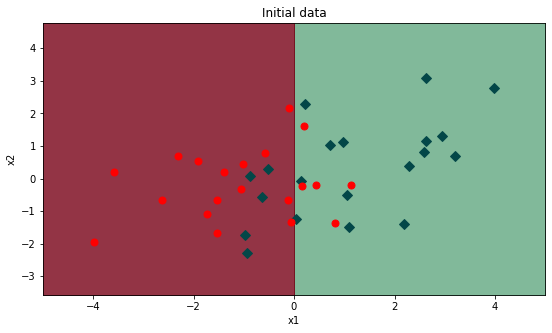

In [ ]:
# Introduction of our particular data

# Dimension

d=20

# Number of datapoints of each class

N0 = 20

N1 = 20

# Mean and Covariance Matrix of each class

mean0=[1 if i == 0 else 0 for i in range(d)]
print(mean0)
cov0 = np.eye(d,d,k=-1) + np.eye(d,d)*2 + np.eye(d,d,k=1)

mean1=[-1 if i == 0 else 0 for i in range(d)]
cov1 = np.eye(d,d,k=-1) + np.eye(d,d)*2 + np.eye(d,d,k=1)

# Creation of Datapoints

np.random.seed(0)
X0 = datagenerator(N0,mean0,cov0)

np.random.seed(2)
X1 = datagenerator(N1,mean1,cov1)

X = np.concatenate((X0, X1),axis = 1)

# We want to move all the points from X0 to the semispace x1>0, and all the points from X1 to the semispace x1<0
# Using the algorithm implemented in Domenec-Zuazua based on the Neural ODE Dynamical System


# (Optional ) Forcing the two first points to have the same first coordinate:

# X[0,1]=X[0,0]

# Plotting our Datapoints

f = plt.figure();
f.set_figwidth(9)
f.set_figheight(5)
plt.xlabel('x1')
plt.ylabel('x2')
limx1 = np.floor(min(X[0]))-abs(min(X[0]))/4#-np.floor((max(Z[0])-min(Z[0]))/2)
limx2 = np.ceil(max(X[0]))+abs(max(X[0]))/4#+np.floor((max(Z[0])-min(Z[0]))/2)
limy1 = np.floor(min(X[1]))-abs(min(X[1]))/4#-np.floor((max(Z[1])-min(Z[1]))/2)
limy2 = np.ceil(max(X[1]))+abs(max(X[1]))/4#+np.floor((max(Z[1])-min(Z[1]))/2)
plt.xlim(limx1,limx2)
plt.ylim(limy1,limy2)
plt.fill_between((0,limx2),limy1,limy2,color = '#2E8B57',alpha =0.6)
plt.fill_between((limx1,0),limy1,limy2,color = '#780116',alpha =0.8)
plt.plot(X[0,:N0],X[1,:N0], 'D',color='#034748',markersize=7)
plt.plot(X[0,N0:],X[1,N0:], 'o',color='#FF0000',markersize=7)

plt.title('Initial data')
plt.show()


In [ ]:
# Applying Step 1:

# We fix the time horizon to 0

T = 0

# Number of switches

M = 0

# History of plots

names_figure = []

# We choose the activation function sigma between ReLU (ReLU), Truncated ReLU (trunReLU) or np.tanh (the algorithm doesn't work)

sigma = TrunReLU

# We set a lower bound for the separation between the first coordinates of our datapoints
# This is to make sure the speed of movement is not too slow 
# (it is lower bounded by the distance between coordinates)
mu=0.05
eps = 0.3

Z = X.copy()

Y,T,M,names_figure = preparation(Z,T,M,names_figure)

# Computing how many points were moved:

print('Number of points moved: ',sum(X[0]!=Y[0]))
print('Time steps used: ',T)

Number of points moved:  35
Time steps used:  48


In [ ]:
# Applying Step 2:

# The two labels are the two semiplanes x1>0 and x1<0

X,T,M,names_figure = classification(Y,T,M,names_figure)

make_gif(names_figure)
            
print('Time steps used: ',T)
print('Number of switches: ',M)

X0 = X[:,:N0]
X1 = X[:,N0:]

print('Class x1>0: ',sum(X0[0]>0),' out of ',N0,' points are correctly labeled')
print('Class x1<0: ',sum(X1[0]<0),' out of ',N1,' points are correctly labeled')

print("Time of execution: --- %s seconds ---" % (time.time() - start_time))

Moving points in direction 8
Classifying point  12
Moving points in direction 17
Classifying point  18
Moving points in direction 6
Classifying point  20
Moving points in direction 1
Classifying point  21
Moving points in direction 9
Classifying point  22
Moving points in direction 14
Classifying point  23
Moving points in direction 14
Classifying point  24
Moving points in direction 12
Classifying point  25
Moving points in direction 18
Classifying point  26
Moving points in direction 11
Classifying point  27
Moving points in direction 10
Classifying point  28
Moving points in direction 9
Classifying point  29
Moving points in direction 9
Classifying point  30
Moving points in direction 13
Classifying point  31
Moving points in direction 9
Classifying point  32
Moving points in direction 7
Classifying point  34
Moving points in direction 12
Classifying point  36
Moviepy - Building video /Users/antonioalvarezlopez/Desktop/Coding/My Programs/Python/Simulación Algoritmo Domènec/Gifs/Si

Moviepy - Done !
Moviepy - video ready /Users/antonioalvarezlopez/Desktop/Coding/My Programs/Python/Simulación Algoritmo Domènec/Gifs/SigmaTrunReLU_dim20_NPoints40_eps0.3_mu0.05.mp4
Time steps used:  302
Number of switches:  82
Class x1>0:  20  out of  20  points are correctly labeled
Class x1<0:  20  out of  20  points are correctly labeled
Time of execution: --- 1.8497939109802246 seconds ---
